# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [32]:
! git clone https://github.com/ds4e/linearModels

fatal: destination path 'linearModels' already exists and is not an empty directory.


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/linearModels/lab/data/airbnb_hw.csv')
print(df.columns)
df = df.rename(columns={'Neighbourhood ': 'Neighbourhood'})
print(df.columns)
df.head()

Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')
Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')


,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [90]:
print(df.dtypes)

Host Id                         int64
Host Since                     object
Name                           object
Neighbourhood                  object
Property Type                  object
Review Scores Rating (bin)    float64
Room Type                      object
Zipcode                       float64
Beds                          float64
Number of Records               int64
Number Of Reviews               int64
Price                          object
Review Scores Rating          float64
dtype: object


In [91]:
# Drop variables that will not be used
df = df.drop(['Host Id', 'Host Since', 'Name', 'Review Scores Rating (bin)', 'Zipcode', 'Number of Records', 'Number Of Reviews'], axis=1)

In [92]:
df.head()

,Neighbourhood,Property Type,Room Type,Beds,Price,Review Scores Rating
0,Brooklyn,Apartment,Entire home/apt,1.0,145,NaN
1,Brooklyn,Apartment,Private room,1.0,37,NaN
2,Manhattan,Apartment,Private room,1.0,28,NaN
3,Manhattan,Apartment,Entire home/apt,3.0,199,NaN
4,Manhattan,Apartment,Private room,3.0,549,96.0


In [93]:
# Price is being read as an object, convert to numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

In [94]:
df['Neighbourhood'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

In [95]:
df['Property Type'].unique()

array(['Apartment', 'House', 'Other', 'Bed & Breakfast', 'Loft',
       'Condominium', 'Townhouse', nan, 'Dorm', 'Boat', 'Cabin', 'Villa',
       'Bungalow', 'Camper/RV', 'Treehouse', 'Tent', 'Hut', 'Lighthouse',
       'Chalet', 'Castle'], dtype=object)

In [96]:
df['Room Type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [97]:
df.groupby('Neighbourhood')[['Price']].mean().reset_index()

,Neighbourhood,Price
0,Bronx,83.308140
1,Brooklyn,124.595122
2,Manhattan,183.964571
3,Queens,100.012747
4,Staten Island,111.312500


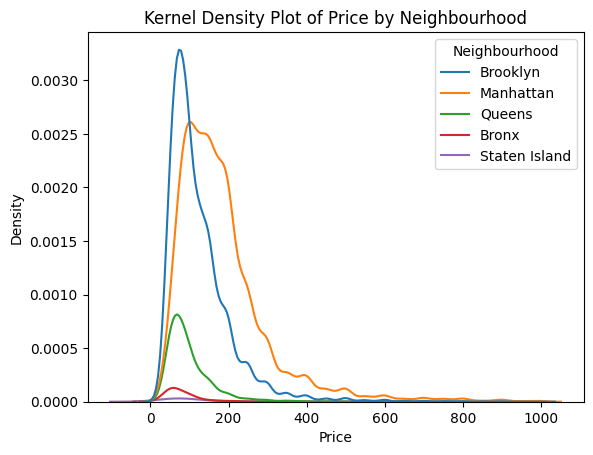

In [98]:
sns.kdeplot(data=df, x='Price', hue='Neighbourhood')
plt.title('Kernel Density Plot of Price by Neighbourhood')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

In [99]:
df.groupby('Property Type')[['Price']].mean().reset_index()

,Property Type,Price
0,Apartment,153.863170
1,Bed & Breakfast,106.572222
2,Boat,153.625000
3,Bungalow,150.750000
4,Cabin,165.000000
5,Camper/RV,103.571429
6,Castle,150.000000
7,Chalet,99.000000
8,Condominium,237.946237
9,Dorm,76.354839


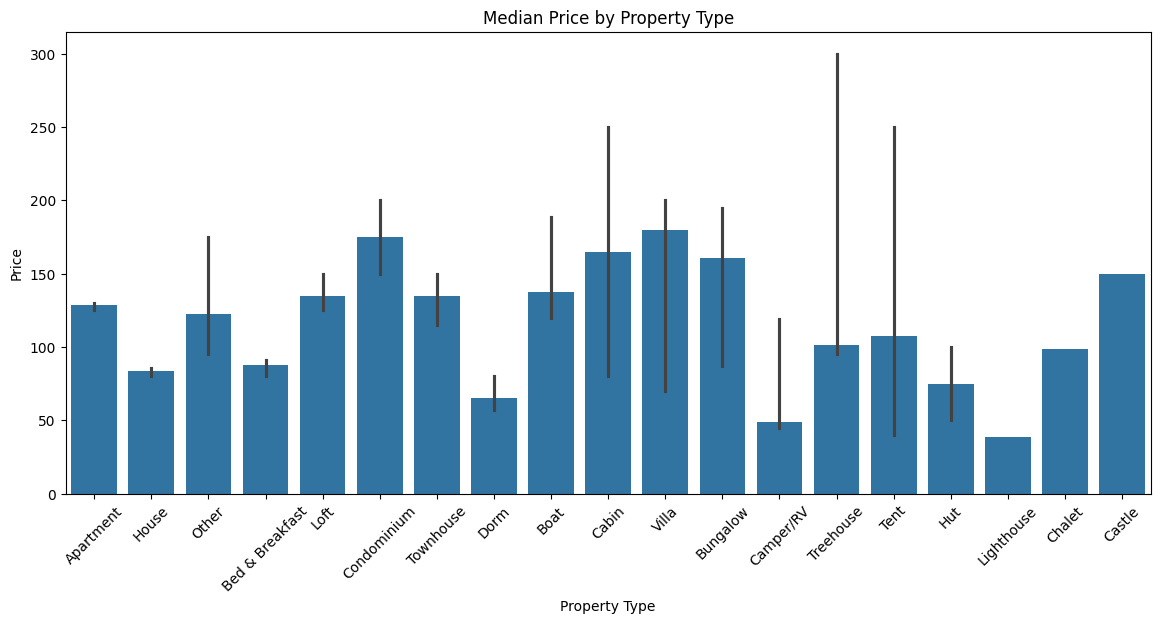

In [100]:
plt.figure(figsize=(14, 6))

sns.barplot(data=df, x='Property Type', y='Price', estimator=np.median)
plt.title('Median Price by Property Type')
plt.xticks(rotation=45)  # Rotate x labels if they overlap
plt.show()

In [101]:
df.groupby('Beds')[['Price']].mean().reset_index()

,Beds,Price
0,0.0,92.000000
1,1.0,124.757670
2,2.0,186.702332
3,3.0,234.928043
4,4.0,280.554830
5,5.0,322.000000
6,6.0,316.313253
7,7.0,341.377778
8,8.0,331.850000
9,9.0,587.142857


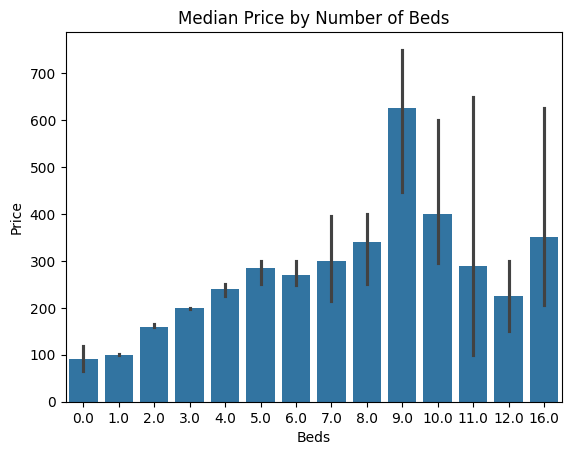

In [102]:
sns.barplot(data=df, x='Beds', y='Price', estimator=np.median)
plt.title('Median Price by Number of Beds')
plt.show()

In [103]:
df.groupby('Room Type')[['Price']].mean().reset_index()

,Room Type,Price
0,Entire home/apt,204.061525
1,Private room,90.663227
2,Shared room,76.553974


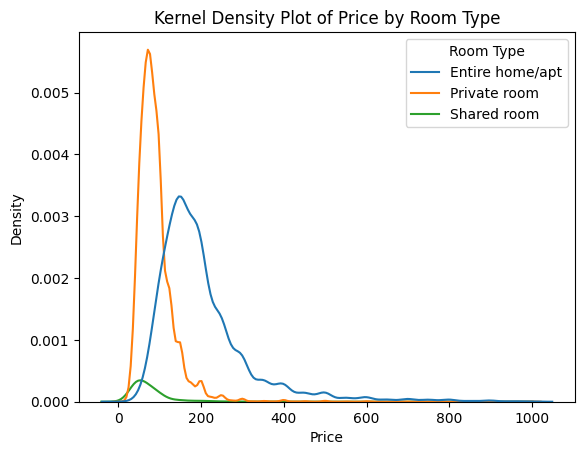

In [104]:
sns.kdeplot(data=df, x='Price', hue='Room Type')
plt.title('Kernel Density Plot of Price by Room Type')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

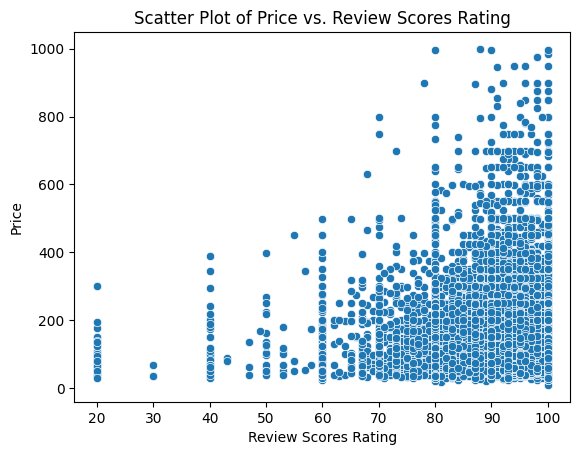

In [105]:
sns.scatterplot(data=df, x='Review Scores Rating', y='Price')
plt.title('Scatter Plot of Price vs. Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price')
plt.show()

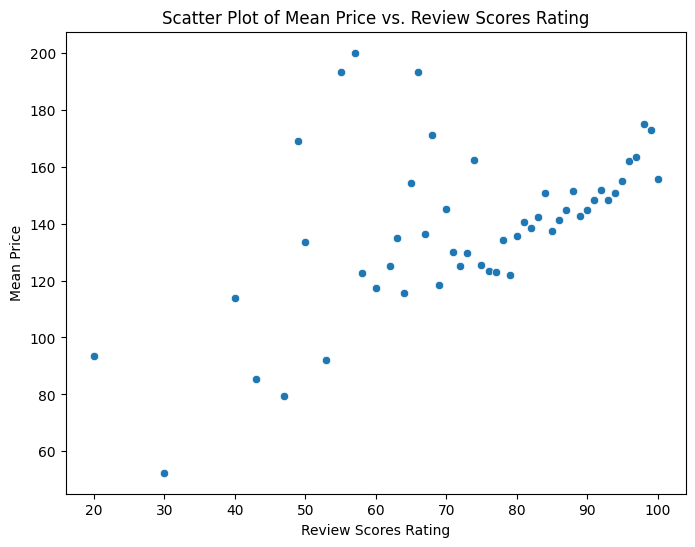

In [106]:
df_grouped = df.groupby('Review Scores Rating')[['Price']].mean().reset_index()

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_grouped, x='Review Scores Rating', y='Price')
plt.title('Scatter Plot of Mean Price vs. Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Mean Price')
plt.show()

In [107]:
df.columns

Index(['Neighbourhood', 'Property Type', 'Room Type', 'Beds', 'Price',
       'Review Scores Rating'],
      dtype='object')

In [108]:
# Transform categorical variables: room type, neighbourhood, property type, room type
df = pd.get_dummies(df, columns=['Neighbourhood', 'Property Type', 'Room Type'], dtype=int)

In [72]:
df.columns

Index(['Beds', 'Price', 'Review Scores Rating', 'Neighbourhood_Brooklyn',
       'Neighbourhood_Manhattan', 'Neighbourhood_Queens',
       'Neighbourhood_Staten Island', 'Property Type_Bed & Breakfast',
       'Property Type_Boat', 'Property Type_Bungalow', 'Property Type_Cabin',
       'Property Type_Camper/RV', 'Property Type_Castle',
       'Property Type_Chalet', 'Property Type_Condominium',
       'Property Type_Dorm', 'Property Type_House', 'Property Type_Hut',
       'Property Type_Lighthouse', 'Property Type_Loft', 'Property Type_Other',
       'Property Type_Tent', 'Property Type_Townhouse',
       'Property Type_Treehouse', 'Property Type_Villa',
       'Room Type_Private room', 'Room Type_Shared room'],
      dtype='object')

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # Import linear regression model

X = df.drop('Price', axis=1)
X.head()


,Beds,Review Scores Rating,Neighbourhood_Brooklyn,Neighbourhood_Manhattan,Neighbourhood_Queens,Neighbourhood_Staten Island,Property Type_Bed & Breakfast,Property Type_Boat,Property Type_Bungalow,Property Type_Cabin,...,Property Type_Hut,Property Type_Lighthouse,Property Type_Loft,Property Type_Other,Property Type_Tent,Property Type_Townhouse,Property Type_Treehouse,Property Type_Villa,Room Type_Private room,Room Type_Shared room
0,1.0,NaN,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.0,NaN,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1.0,NaN,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,3.0,NaN,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3.0,96.0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
